In [1]:
%load_ext autoreload

In [2]:
%autoreload

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import math
import sys
sys.path.append("..")
import physics
sys.path.append("../..")
from spec.spectrum import *
import spec.spectools as spectools
import xsecs

In [3]:
class Rates(object):
  
    def __init__(self, E_spec, n, den=[1,1,1], dNdW=np.zeros((2,1)), rates=np.zeros(4)):
        self.energy = E_spec.eng[n]
        self.n = n
        self.dNdE = E_spec.dNdE[n]
        self.den = den
        self.rates = rates
        self.v = np.sqrt(2*np.array([E_spec.eng[n]])/physics.me)*physics.c #units?
        self.mult = self.den*self.v
        self.dNdW = np.zeros((2, self.n ))
    
    def ion_dNdW_calc_H(self): #uses new integration method
        '''Fills *self.dNdW[0,:]* with the discretized singly differential xsec in rate form
        '''
        eng_temp = E_spec.eng[0:self.n]
        ion_s_rates = xsecs.ionize_s_cs_H_2(self.energy, eng_temp)    #possible problem with np type
        self.dNdW[0] = ion_s_rates *self.mult[0]                      #dNdE? ;also, [0,:]?
        return self.dNdW
    
    def ion_rate_calc(self):
        '''Fills *self.rate[1:3]* vector by calculating total xsec and then converting to rate
        '''
        ion_rates = xsecs.ionize_cs(self.energy*np.ones(3),np.array([1,2,3]))*self.mult
        self.rates[1:4] = ion_rates
        return self.rates
    
    def heat_rate_calc(self, x_e, rs):
        '''Fills *self.rate[0]* vector with fraction going to heating
            x_e and rs...
        '''
        dE = xsecs.heating_dE(self.energy, x_e, rs, nH=physics.nH)
        delta_dNdE = np.zeros(len(E_spec.dNdE))
        np.put(delta_dNdE, self.n, self.dNdE)
        delta = Spectrum(E_spec.eng, delta_dNdE, rs)
        shift_delta_eng = E_spec.eng+dE
        delta.shift_eng(shift_delta_eng)
        delta.rebin(E_spec.eng)
        
        heating_frac = delta.dNdE[self.n]/self.dNdE
        self.rates[0] = 1-heating_frac #units? 
        return(self.rates)
    
    def E_loss(self):
        '''loss fraction
        '''
        E_loss_ion=13.6*self.rates[1]
        E_loss_heat=(E_spec.eng[self.n]-E_spec.eng[self.n-1])*self.rates[0]
        E_frac = E_loss_ion/E_loss_heat
        return(E_frac)
    
    def ion_int_calc(self):
        '''gives total ionization rate
        '''
        bin_width = get_log_bin_width(E_spec.eng[0:self.n])
        integ = 0
        for i in range(self.n):
            integ += self.dNdW[0,i-1]*bin_width[i]*E_spec.eng[i]
        return integ
        
        

In [4]:
def electron_low_e(E_spec, rs, ion_frac=[0.001,0.001,0.001], den=[1,1,1], dt=1 ,all_outputs=False):
   
    N = len(E_spec.eng)
    den[0]=(physics.nH*(1-ion_frac[0]))*(rs)**3 #units?
    
    R = np.zeros((2,N))
    R[1,0] = 1
    R[1,1] = 1
    R[1,2] = 1
    
    for n in range(3,N):
        e_rates = Rates(E_spec, n, den)
        e_rates.ion_rate_calc()
        e_rates.heat_rate_calc(ion_frac[0], rs)
        e_rates.ion_dNdW_calc_H() 
        
        delta_E_spec = np.ediff1d(E_spec.eng)[0:(n)] #bin widths
        
        discrete_dN_dEdt_i = e_rates.dNdW[0]
        
        h_init=np.zeros(n)
        h_init[n-2] = e_rates.rates[0]
        h_init[n-1] = 1 - e_rates.rates[0]
        discrete_dN_dEdt_h = h_init/delta_E_spec
        
        
        R_in = ((13.6*e_rates.rates[1]) + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_i[0:n-1]*R[0,0:n-1]*delta_E_spec[0:n-1]) \
            + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*R[0,0:n-1]*delta_E_spec[0:n-1])) \
            /(e_rates.energy*(np.sum(discrete_dN_dEdt_i[0:n-1])+np.sum(discrete_dN_dEdt_h[0:n-1])))
            
        
        R_hn = ((e_rates.energy*e_rates.rates[0]-np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*delta_E_spec[0:n-1])) \
            + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_i[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1]) \
            + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1])) \
            /(e_rates.energy*(np.sum(discrete_dN_dEdt_i[0:n-1])+np.sum(discrete_dN_dEdt_h[0:n-1])))
            

        R[0,n] = R_in/(R_in+R_hn)
        R[1,n] = R_hn/(R_in+R_hn)
        
        if n==100 or n == 400:
            print('energy')
            print(e_rates.energy)
            print('rs')
            print(rs)
            print('ion')
            print(13.6*e_rates.rates[1])
            print(np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_i[0:n-1]*R[0,0:n-1]*delta_E_spec[0:n-1]))
            print(np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*R[0,0:n-1]*delta_E_spec[0:n-1]))
            print('heat')
            print(e_rates.energy*e_rates.rates[0]-np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*delta_E_spec[0:n-1]))
            print(np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_i[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1]))
            print(np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1]))
        
        #R[0,n] = R_in
        #R[1,n] = R_hn
        
        #print(n, e_rates.energy,R_in,R_hn)
        #print(e_rates.energy*e_rates.rates[0], np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*delta_E_spec[0:n-1]), np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_i[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1]),np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1]) )
        
        
    return R
    

<h1>Testing specific spectra:</h1>

In [5]:
eng1 = np.logspace(-4.,4.,num = 500)
#dNdE1 = np.logspace(0.,5.,num = 500)
dNdE1 = np.ones(500)
rs=1
E_spec = Spectrum(eng1,dNdE1,rs)

In [6]:
%%capture
results_ion_frac_0 = electron_low_e(E_spec,10**3)

In [7]:
%%capture
results_ion_frac_1 = electron_low_e(E_spec,10**1)

energy
0.00401057288086
rs
10.0
ion
0.0
0.0
0.0
heat
4.49069931844e-10
0.0
5.86068195652e-09
energy
258.71740786
rs
10.0
ion
8.48832706949e-11
3.63816528721e-13
2.67247198591e-11
heat
2.09332920564e-12
8.26313923059e-15
5.94714898379e-13
0
energy
0.00401057288086
rs
20.0
ion
0.0
0.0
0.0
heat
3.59255944252e-09
0.0
4.68854554925e-08
energy
258.71740786
rs
20.0
ion
6.79066165559e-10
2.90988872684e-12
1.87190242516e-10
heat
1.46512601727e-11
6.67486167714e-14
4.01912165084e-12
1
energy
0.00401057288086
rs
30.0
ion
0.0
0.0
0.0
heat
1.21248881232e-08
0.0
1.58238412349e-07
energy
258.71740786
rs
30.0
ion
2.29184830876e-09
9.82093322274e-12
6.15055300374e-10
heat
4.81445274629e-11
2.25217811943e-13
1.32650199122e-11
2
energy
0.00401057288086
rs
40.0
ion
0.0
0.0
0.0
heat
2.87404755528e-08
0.0
3.75083644106e-07
energy
258.71740786
rs
40.0
ion
5.43252932447e-09
2.32789566952e-11
1.44409018846e-09
heat
1.13039777104e-10
5.34142053715e-13
3.11592884442e-11
3
energy
0.00401057288086
rs
50.0
ion
0.0


/Users/cannonvogel/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


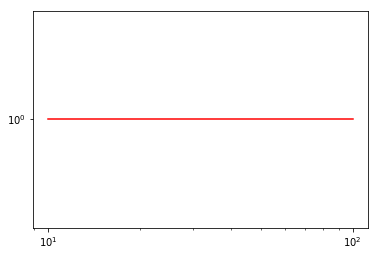

In [8]:
x=np.linspace(10,100,num = 10)
y=np.zeros((10,1))

for k,rs in enumerate(x):
    y[k] = electron_low_e(E_spec, rs)[1,300]
    print(k)

plt.plot(x,y, 'r')
plt.xscale('log')
plt.yscale('log')
plt.show()
#heat rate versus redshift

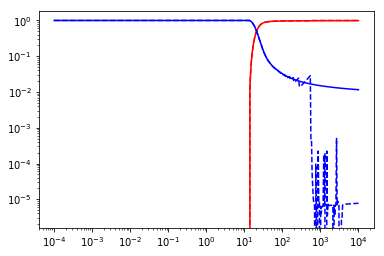

In [9]:
np.set_printoptions(threshold = np.nan)
#print(np.transpose([E_spec.eng, results_ion_frac_0[0,:],results_ion_frac_0[1,:]]))
plt.plot(E_spec.eng, results_ion_frac_0[0,:], 'r')   #10**3
plt.plot(E_spec.eng, results_ion_frac_1[0,:], 'r--') #10**1
plt.plot(E_spec.eng, results_ion_frac_0[1,:], 'b')
plt.plot(E_spec.eng, results_ion_frac_1[1,:], 'b--')
plt.xscale('log')
plt.yscale('log')
plt.show()